In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='NanumGothic')
from tqdm import tqdm
import gc

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name()}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

PyTorch 버전: 2.8.0+cpu
CUDA 사용 가능: False
사용 디바이스: cpu


In [15]:
try:
    styles = pd.read_csv('processed_styles.csv')
    print(f"전처리된 데이터 로드 성공: {len(styles):,}개")
except FileNotFoundError:
    print("전처리된 파일이 없어 직접 처리합니다...")
    
    csv_path = '../data/fashion-dataset/styles.csv'
    image_dir = '../data/fashion-dataset/images'
    
    styles = pd.read_csv(csv_path, on_bad_lines='skip')
    styles = styles.dropna(subset=['id'])
    styles['id'] = styles['id'].astype(int)
    styles['image_path'] = styles['id'].astype(str).apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    styles = styles[styles['image_path'].apply(os.path.exists)]
    styles = styles.reset_index(drop=True)
     
    print(f"데이터 전처리: {len(styles):,}개")

USE_SAMPLE = False
SAMPLE_SIZE = 1000

if USE_SAMPLE and len(styles) > SAMPLE_SIZE:
    styles_sample = styles.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"샘플 데이터 사용: {len(styles_sample):,}개")
    styles_work = styles_sample
else:
    styles_work = styles
    print(f"전체 데이터 사용: {len(styles_work):,}개")

전처리된 데이터 로드 성공: 861개
전체 데이터 사용: 861개


### ResNet50 모델 로드

In [16]:
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

model = ResNet50FeatureExtractor(base_model)
model = model.to(device)
model.eval() 

print(f"   모델 디바이스: {next(model.parameters()).device}")
test_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    test_output = model(test_input)
print(f"   입력 크기: (batch_size, 3, 224, 224)")
print(f"   출력 크기: {test_output.shape}")

   모델 디바이스: cpu
   입력 크기: (batch_size, 3, 224, 224)
   출력 크기: torch.Size([1, 2048])


In [17]:
class FashionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, idx
            
        except Exception as e:
            print(f"이미지 로드 오류 {img_path}: {e}")
            if self.transform:
                dummy_image = Image.new('RGB', (224, 224), (0, 0, 0))
                image = self.transform(dummy_image)
            else:
                image = torch.zeros(3, 224, 224)
            
            return image, -1

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("이미지 전처리 파이프라인")
print("   1. 리사이징: 224x224")
print("   2. 텐서 변환: PIL -> Tensor")
print("   3. 정규화: ImageNet 표준")

dataset = FashionDataset(styles_work, transform=transform)

BATCH_SIZE = 16
NUM_WORKERS = 0

dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"데이터로더")
print(f"   배치 크기: {BATCH_SIZE}")
print(f"   워커 수: {NUM_WORKERS}")
print(f"   총 배치 수: {len(dataloader)}")

이미지 전처리 파이프라인
   1. 리사이징: 224x224
   2. 텐서 변환: PIL -> Tensor
   3. 정규화: ImageNet 표준
데이터로더
   배치 크기: 16
   워커 수: 0
   총 배치 수: 54


### 특성 추출

In [18]:
all_features = []
valid_indices = []

start_time = time.time()
print(f"배치 크기: {BATCH_SIZE}, 총 배치 수: {len(dataloader)}")

model.eval()
with torch.no_grad():
    for batch_idx, (images, indices) in enumerate(tqdm(dataloader, desc="특성 추출")):
        images = images.to(device)
        features = model(images)
        features_np = features.cpu().numpy()
        
        valid_batch_indices = [idx.item() for idx in indices if idx.item() != -1]
        valid_features = features_np[indices != -1]
        
        all_features.append(valid_features)
        valid_indices.extend(valid_batch_indices)
        
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()

end_time = time.time()
processing_time = end_time - start_time

if all_features:
    features = np.vstack(all_features)
else:
    features = np.array([])
print(f"   처리 시간: {processing_time:.2f}초")
print(f"   성공한 이미지: {len(features):,}개")
print(f"   실패한 이미지: {len(styles_work) - len(features):,}개")
print(f"   성공률: {len(features)/len(styles_work)*100:.1f}%")
if len(features) > 0:
    print(f"   평균 처리 시간: {processing_time/len(features):.4f}초/이미지")
    print(f"   특성 벡터 형태: {features.shape}")

배치 크기: 16, 총 배치 수: 54


특성 추출: 100%|██████████| 54/54 [01:08<00:00,  1.27s/it]

   처리 시간: 68.44초
   성공한 이미지: 861개
   실패한 이미지: 0개
   성공률: 100.0%
   평균 처리 시간: 0.0795초/이미지
   특성 벡터 형태: (861, 2048)


### 결과 저장

In [19]:
if len(features) > 0:
    valid_styles = styles_work.iloc[valid_indices].reset_index(drop=True)
    
    print(f"유효한 데이터: {len(valid_styles):,}개")
    
    embeddings_dir = '../embeddings'
    os.makedirs(embeddings_dir, exist_ok=True)
    
    torch_embeddings_path = os.path.join(embeddings_dir, 'torch_embeddings.npy')
    np.save(torch_embeddings_path, features)
    print(f"PyTorch 임베딩 저장: {torch_embeddings_path}")
    
    torch_metadata_path = os.path.join(embeddings_dir, 'torch_metadata.csv')
    valid_styles.to_csv(torch_metadata_path, index=False)
    print(f"메타데이터 저장: {torch_metadata_path}")
    
    stats = {
        'framework': 'PyTorch',
        'model': 'ResNet50',
        'total_images': len(styles_work),
        'successful_images': len(features),
        'failed_images': len(styles_work) - len(features),
        'success_rate': len(features)/len(styles_work)*100,
        'processing_time_seconds': processing_time,
        'avg_time_per_image': processing_time/len(features) if len(features) > 0 else 0,
        'batch_size': BATCH_SIZE,
        'num_workers': NUM_WORKERS,
        'feature_dim': features.shape[1],
        'device': str(device),
        'pytorch_version': torch.__version__
    }
    stats_df = pd.DataFrame([stats])
    torch_stats_path = os.path.join(embeddings_dir, 'torch_stats.csv')
    stats_df.to_csv(torch_stats_path, index=False)
    print(f"처리 통계 저장: {torch_stats_path}")
else:
    print("ERROR: 추출된 특성이 없습니다!")


유효한 데이터: 861개
PyTorch 임베딩 저장: ../embeddings\torch_embeddings.npy
메타데이터 저장: ../embeddings\torch_metadata.csv
처리 통계 저장: ../embeddings\torch_stats.csv


### 특성 벡터 분석

특성 벡터 통계:
   평균: 0.375098
   표준편차: 0.409921
   최솟값: 0.000000
   최댓값: 7.188450


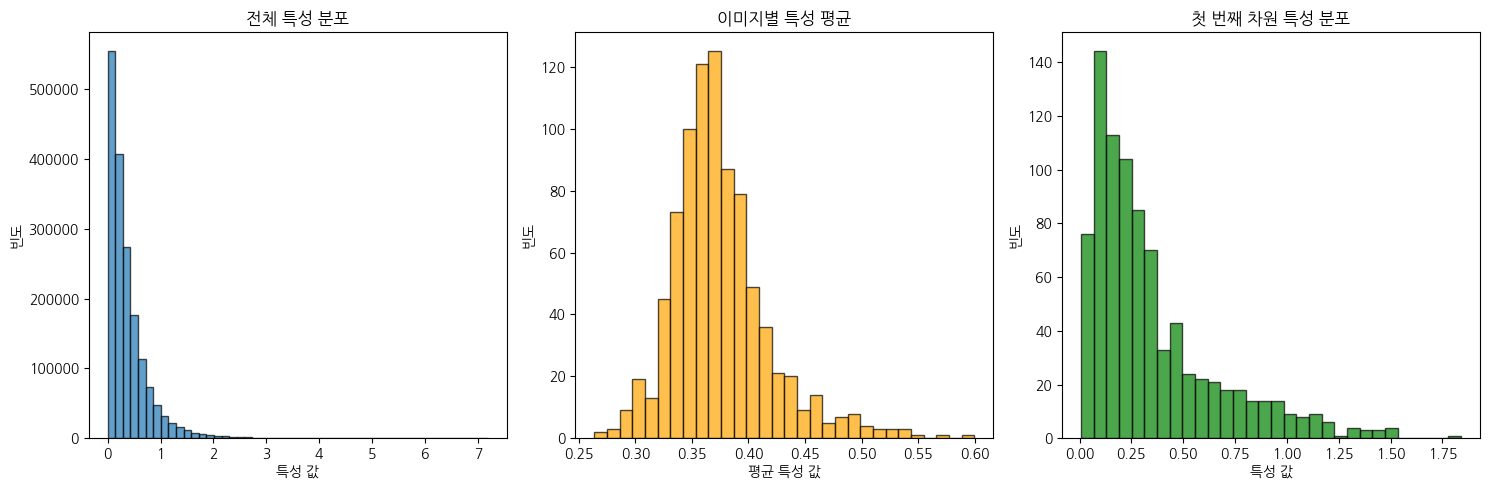


카테고리별 특성 분석:


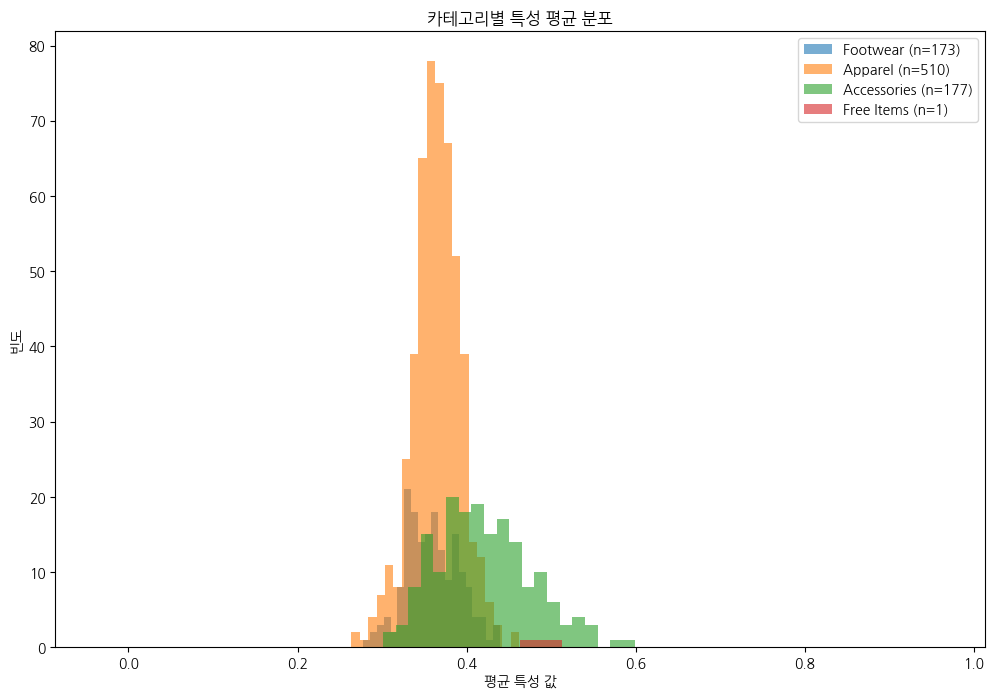

In [20]:
if len(features) > 0:
    print(f"특성 벡터 통계:")
    print(f"   평균: {np.mean(features):.6f}")
    print(f"   표준편차: {np.std(features):.6f}")
    print(f"   최솟값: {np.min(features):.6f}")
    print(f"   최댓값: {np.max(features):.6f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(features.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('전체 특성 분포')
    plt.xlabel('특성 값')
    plt.ylabel('빈도')
    
    plt.subplot(1, 3, 2)
    feature_means = np.mean(features, axis=1)
    plt.hist(feature_means, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.title('이미지별 특성 평균')
    plt.xlabel('평균 특성 값')
    plt.ylabel('빈도')
    
    plt.subplot(1, 3, 3)
    plt.hist(features[:, 0], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.title('첫 번째 차원 특성 분포')
    plt.xlabel('특성 값')
    plt.ylabel('빈도')
    
    plt.tight_layout()
    plt.show()
    
    if 'masterCategory' in valid_styles.columns:
        print(f"\n카테고리별 특성 분석:")
        
        categories = valid_styles['masterCategory'].unique()[:5]
        
        plt.figure(figsize=(12, 8))
        
        for i, category in enumerate(categories):
            cat_indices = valid_styles['masterCategory'] == category
            cat_features = features[cat_indices]
            
            if len(cat_features) > 0:
                cat_mean = np.mean(cat_features, axis=1)
                plt.hist(cat_mean, alpha=0.6, label=f'{category} (n={len(cat_features)})', bins=20)
        
        plt.title('카테고리별 특성 평균 분포')
        plt.xlabel('평균 특성 값')
        plt.ylabel('빈도')
        plt.legend()
        plt.show()

### 유사도 테스트

In [21]:
if len(features) > 0:
    test_idx = 0
    test_feature = features[test_idx].reshape(1, -1)
    test_info = valid_styles.iloc[test_idx]
    
    print(f"테스트 이미지 정보:")
    print(f"   ID: {test_info['id']}")
    if 'productDisplayName' in test_info:
        print(f"   상품명: {test_info['productDisplayName']}")
    if 'masterCategory' in test_info:
        print(f"   카테고리: {test_info['masterCategory']}")
    
    similarities = cosine_similarity(test_feature, features)[0]
    similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"\n가장 유사한 상품 5개:")
    for i, idx in enumerate(similar_indices, 1):
        sim_info = valid_styles.iloc[idx]
        similarity_score = similarities[idx]
        
        print(f"   {i}. ID: {sim_info['id']}, 유사도: {similarity_score:.4f}")
        if 'productDisplayName' in sim_info:
            print(f"      상품명: {sim_info['productDisplayName']}")
        if 'masterCategory' in sim_info:
            print(f"      카테고리: {sim_info['masterCategory']}")

테스트 이미지 정보:
   ID: 10268
   상품명: Clarks Men Hang Work Leather Black Formal Shoes
   카테고리: Footwear

가장 유사한 상품 5개:
   1. ID: 10297, 유사도: 0.9622
      상품명: Clarks Men Black Leather Loafers
      카테고리: Footwear
   2. ID: 10281, 유사도: 0.9493
      상품명: Clarks Men Hang Spring Leather Black Formal Shoes
      카테고리: Footwear
   3. ID: 10265, 유사도: 0.9492
      상품명: Clarks Men Goto Eat Tobacco Leather Brown Formal Shoes
      카테고리: Footwear
   4. ID: 10301, 유사도: 0.9486
      상품명: Clarks Brown Leather Casual Shoes
      카테고리: Footwear
   5. ID: 10286, 유사도: 0.9472
      상품명: Clarks Men Hang Tough Leather Black Formal Shoes
      카테고리: Footwear


### TensorFlow 결과와 비교

In [23]:
try:
    tf_embeddings = np.load('../embeddings/tf_embeddings.npy')
    tf_stats = pd.read_csv('../embeddings/tf_stats.csv')
    
    print(f"TensorFlow 결과 발견!")
    print(f"   TF 특성 형태: {tf_embeddings.shape}")
    print(f"   PyTorch 특성 형태: {features.shape}")
    
    if len(features) > 0:
        tf_time = tf_stats.iloc[0]['processing_time_seconds']
        torch_time = processing_time
        
        print(f"\n처리 시간 비교:")
        print(f"   TensorFlow: {tf_time:.2f}초")
        print(f"   PyTorch: {torch_time:.2f}초")
        print(f"   속도 차이: {((tf_time - torch_time) / tf_time * 100):+.1f}%")
        
        if tf_embeddings.shape == features.shape:
            correlation = np.corrcoef(tf_embeddings[0], features[0])[0, 1]
            print(f"\n특성 벡터 상관관계 (첫 샘플): {correlation:.4f}")
            
            tf_mean = np.mean(tf_embeddings)
            torch_mean = np.mean(features)
            print(f"   TF 평균: {tf_mean:.6f}")
            print(f"   PyTorch 평균: {torch_mean:.6f}")
except FileNotFoundError:
    print("TensorFlow 결과 파일이 없음음.")

TensorFlow 결과 발견!
   TF 특성 형태: (861, 2048)
   PyTorch 특성 형태: (861, 2048)

처리 시간 비교:
   TensorFlow: 88.35초
   PyTorch: 68.44초
   속도 차이: +22.5%

특성 벡터 상관관계 (첫 샘플): 0.0041
   TF 평균: 0.412421
   PyTorch 평균: 0.375098


### Summary

In [24]:
if len(features) > 0:
    print(f"처리 결과:")
    print(f"   - 총 처리 이미지: {len(styles_work):,}개")
    print(f"   - 성공한 이미지: {len(features):,}개")
    print(f"   - 특성 벡터 차원: {features.shape[1]}")
    print(f"   - 처리 시간: {processing_time:.2f}초")
    print(f"   - 평균 속도: {len(features)/processing_time:.1f}개/초")
    print(f"   - 사용 디바이스: {device}")
    print(f"")
    print(f"저장된 파일:")
    print(f"   - 임베딩: {torch_embeddings_path}")
    print(f"   - 메타데이터: {torch_metadata_path}")
    print(f"   - 통계: {torch_stats_path}")
else:
    print("ERROR.")

처리 결과:
   - 총 처리 이미지: 861개
   - 성공한 이미지: 861개
   - 특성 벡터 차원: 2048
   - 처리 시간: 68.44초
   - 평균 속도: 12.6개/초
   - 사용 디바이스: cpu

저장된 파일:
   - 임베딩: ../embeddings\torch_embeddings.npy
   - 메타데이터: ../embeddings\torch_metadata.csv
   - 통계: ../embeddings\torch_stats.csv
